<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='' align='centre' width='30%'></img>

# OLCI spatial plotting, quality control and data interrogation

    Version: 3.0
    Date:    10/07/2020
    Author:  Ben Loveday (InnoFlair / Plymouth Marine Laboratory) and Hayley Evers-King (EUMETSAT)
    Credit:  This code was developed for EUMETSAT under contracts for the European Commission Copernicus 
             programme.
    License: This code is offered as open source and free-to-use in the public domain, 
             with no warranty, under the MIT license associated with this code repository.

This aim of this code is to introduce you to Python and to simply import a netCDF file in to your python workspace, conduct some basic operations, and plot an image. In this case, we will be using a level-2 OLCI image, but the script can be easily adapted to plot any netCDF variable.

<div class="alert alert-block alert-warning">
    <b>Get the WEkEO User credentials</b>
<hr>
If you want to download the data to use this notebook, you will need WEkEO User credentials. If you do not have these, you can register <a href="https://www.wekeo.eu/web/guest/user-registration" target="_blank">here</a>.


The first step in any python code is usually to import libraries that you will need. Libraries are usually code modules that perform specific tasks or provide specific capability (e.g. statistical analysis or plotting routines). In this case we will import the xarray library for handling netCDF files, the numpy library which will help to conduct various operations on the data, and the matplotlib plotting library to generate some images. We will also import the os library, that allows python access to some command-line-eqsue capability like 'list directory', as well as the python library that governs the reporting of warning (so that we can turn them off here, and make the code run without being so 'noisy').

In [1]:
%matplotlib inline

# libraries are imported here, and we can import any library with an alias that allows us easy access to them later.
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.core.display import display, HTML
import json
from zipfile import ZipFile
import subprocess
import shlex


import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c2eiba_i because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


The second step is install the WEKEO HDA client.
The WEkEO HDA client is a python based library and it provides support for both Python 2.7.x and Python 3.

In order to install the WEkEO HDA client via the package management system pip, you have to running on Unix/Linux the command shown below.

In [2]:
pip install -U hda

Requirement already up-to-date: hda in /opt/conda/lib/python3.8/site-packages (0.2.2)
Note: you may need to restart the kernel to use updated packages.


Please verify the following requirements are installed before skipping to the next step:
   - Python 3
   - requests
   - tqdm

#### Load WEkEO HDA client

The hda client provides a fully compliant Python 3 client that can be used to search and download products using the Harmonized Data Access WEkEO API.
HDA is RESTful interface allowing users to search and download WEkEO datasets.
Documentation about its usage can be found at https://www.wekeo.eu/.

In [3]:
from hda import Client

Usually we also define functions at the top of a Python script. Functions are routines that can be called elsewhere in our script and perform a specific task. Typically we would use a function to take care of any process that we are going to perform more than once. The box below defines a function that will mask our data according to quality flags. We will call this function later on.

In [4]:
def flag_data_fast(flags_we_want, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    
    for flag in flags_we_want:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + " not present")
    
    return (flag_data & flag_bits) > 0

Now we will start our script, proper.

To run this script, we will download some data from WEkEO harmonised data access. WEkEO provides access to a huge number of datasets through its **'harmonised-data-access'** API. This allows us to query the full data catalogue and download data quickly and directly onto the Jupyter Lab. You can search for what data is available <a href="https://wekeo.eu/data?view=catalogue">here</a>

In order to use the HDA client we need to provide some authentication credentials. Each user first makes sure the file "$HOME/.hdarc" exists with the URL to the API end point and your user and password.

For example, to search for the file .hdarc in the $HOME diretory, the user would open a terminale and run the following command:

Then he could copy the code below in the file "$HOME/.hdarc" (in your Unix/Linux environment) and adapt the following template with the credentials of your WEkEO account:

Lastly, we will tell the notebook where to find the query we will use to find the data. These 'JSON' queries are what we use to ask WEkEO for data. They have a very specific form, but allow us quite fine grained control over what data to get. You can find the example one that we will use here: JSON_templates/EO_EUM_DAT_SENTINEL-3_OL_2_WRR___.json

If he doesn't have a WEkEO account, please self register at the WEkEO registration page https://my.wekeo.eu/web/guest/user-registration.

In [5]:
# set this key to true to download data.
download_data = True

In [6]:
# where the data should be downloaded to:
download_dir_path = os.getcwd()
# where we can find our data query form:
JSON_query_dir = os.path.join(os.getcwd(),'JSON_templates')
# HDA-API loud and noisy?
verbose = False

# make the output directory if required
if not os.path.exists(download_dir_path):
    os.makedirs(download_dir_path)

Now we have set how we want the script to run, we are ready to get some data. We start this process by telling the script what kind of data we want. In this case, this is OLCI L2 reduced resolution data, which has the following designation on WEkEO: **EO:EUM:DAT:SENTINEL-3:OL_2_WRR___**.

In [7]:
# OLCI REDUCED RESOLUTION LEVEL 2 DATASET ID
dataset_id = "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___"

Here, we use this dataset_id to find the correct, locally stored JSON query file which describes the data we want. The query file is called: **JSON_templates/cyano/EO_EUM_DAT_SENTINEL-3_OL_2_WFR___.json**

You can edit this query if you want to get different data, but be aware of asking for too much data - you could be here a while and might run out of space to use this data in the JupyterLab. The box below gets the correct query file.

In [8]:
# find query file
JSON_query_file = os.path.join(JSON_query_dir,dataset_id.replace(':','_')+".json")
if not os.path.exists(JSON_query_file):
    print('Query file ' + JSON_query_file + ' does not exist')
else:
    print('Found JSON query file for '+dataset_id)

Found JSON query file for EO:EUM:DAT:SENTINEL-3:OL_2_WFR___


Now we have a query, we need to launch it to WEkEO to get our data. The box below uses directly the client to download data.

If you want more information, you can check out the **wekeo-hda** tool kit in the parent training directory. The code below will report some information as it runs. At the end, it should tell you that one product has been downloaded.

In [9]:
if download_data:
    # load the query
    with open(JSON_query_file, 'r') as f:
        query = json.load(f)

    # download data
    print('Downloading data...')
    c = Client(debug=True)

    matches = c.search(query)
    print(matches)
    matches.download()

2021-12-14 12:15:06,459 DEBUG HDA {'url': 'https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker', 'token': None, 'user': 'Stefano', 'password': '12qwaszx', 'quiet': False, 'verify': True, 'timeout': None, 'sleep_max': 120, 'retry_max': 500, 'progress': True}
2021-12-14 12:15:06,460 DEBUG ===> GET https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/gettoken
2021-12-14 12:15:06,463 DEBUG Starting new HTTPS connection (1): wekeo-broker.apps.mercator.dpi.wekeo.eu:443


2021-12-14 12:15:09,229 DEBUG https://wekeo-broker.apps.mercator.dpi.wekeo.eu:443 "GET /databroker/gettoken HTTP/1.1" 200 61
2021-12-14 12:15:09,231 DEBUG <=== {"access_token": "3810435d-a836-3f13-9261-0b8c9a8acacd"}
2021-12-14 12:15:09,231 DEBUG Token is 3810435d-a836-3f13-9261-0b8c9a8acacd
2021-12-14 12:15:09,232 DEBUG ===> POST https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest
2021-12-14 12:15:09,233 DEBUG ===> POST {"datasetId": "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___", "boundingBoxValues": [{"na...
2021-12-14 12:15:13,857 DEBUG https://wekeo-broker.apps.mercator.dpi.wekeo.eu:443 "POST /databroker/datarequest HTTP/1.1" 200 93
2021-12-14 12:15:13,859 DEBUG <=== {"jobId": "sYZ5JGYZmvLfBqU06iUyIlHmh6o", "status": "started", "results": [], ...
2021-12-14 12:15:13,859 DEBUG Sleeping 1 seconds
2021-12-14 12:15:14,861 DEBUG ===> GET https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/sYZ5JGYZmvLfBqU06iUyIlHmh6o
2021-12-14 12:15:14,945 DEBUG https:

SearchResults[items=1,volume=247M,jobId=sYZ5JGYZmvLfBqU06iUyIlHmh6o]


2021-12-14 12:15:21,580 DEBUG https://wekeo-broker.apps.mercator.dpi.wekeo.eu:443 "POST /databroker/dataorder HTTP/1.1" 200 80
2021-12-14 12:15:21,581 DEBUG <=== {"orderId": "gbOop-DTChojcIfK2LJZGoNxvdE", "status": "running", "message": null}
2021-12-14 12:15:21,582 DEBUG Sleeping 1 seconds
2021-12-14 12:15:22,584 DEBUG ===> GET https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/status/gbOop-DTChojcIfK2LJZGoNxvdE
2021-12-14 12:15:22,676 DEBUG https://wekeo-broker.apps.mercator.dpi.wekeo.eu:443 "GET /databroker/dataorder/status/gbOop-DTChojcIfK2LJZGoNxvdE HTTP/1.1" 200 373
2021-12-14 12:15:22,677 DEBUG <=== {"status": "completed", "message": "Done!", "downloadUri": "wekeo-broker-stor...
2021-12-14 12:15:22,677 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/gbOop-DTChojcIfK2LJZGoNxvdE to S3A_OL_2_WFR____20210628T100847_20210628T101147_20210629T220545_0179_073_236_2340_MAR_O_NT_003 (247M)
2021-12-14 12:15:23,380 DEBUG https

Sentinel data is usually distributed as a zip file. If these data are archives, the user must extract them before load. But the archive could not have the zip extension; in this case the user may add '.zip' at the end of the file name.
The cell below make this, but if you have an already decompressed data this step is not necessary and the data can be directly loaded.

In [10]:
#rename S3 file
download_dir_path = os.getcwd()

for item in os.listdir(download_dir_path): 
    cmd = shlex.split('file --mime-type {0}'.format(item))
    result = subprocess.check_output(cmd)
    mime_type = result.split()[-1]
    if item.startswith('S3') and not item.endswith('.zip') and ('_OL_2_WFR_' in item) and mime_type == b'application/zip':
        os.rename(os.path.join(download_dir_path, item), os.path.join(download_dir_path, item +".zip"))

In case you have permission issues when renaming the archive with the code above, please manually do that by right-clicking the file, then rename, then add .zip to the end of the filename.

For example:
- From: S3A_OL_2_WFR____20210628T100847_20210628T101147_20210629T220545_0179_073_236_2340_MAR_O_NT_003   
- To: S3A_OL_2_WFR____20210628T100847_20210628T101147_20210629T220545_0179_073_236_2340_MAR_O_NT_003.zip

Now we must unzip the file. The box below handles this.

In [11]:
if download_data:
    # unzip file
    HAPI_dict = []
    for filename in os.listdir(os.getcwd()):
        if os.path.splitext(filename)[-1] == '.zip':
            HAPI_dict.append(filename)
            print('Unzipping file')
            try:
                with ZipFile(filename, 'r') as zipObj:
                    # Extract all the contents of zip file in current directory
                    zipObj.extractall(os.path.dirname(filename))

                # clear up the zip file
                os.remove(filename)
            except:
                print("Failed to unzip....")

Unzipping file


In [12]:
if download_data:
    unzipped_file = HAPI_dict[0].replace('.zip','.SEN3')
    
else:
    unzipped_file = glob.glob(os.path.join(download_dir_path,'*OL_2_WRR*.SEN3'))

input_root    = os.path.dirname(unzipped_file)
input_path    = os.path.basename(unzipped_file)
file_name_chl = 'chl_nn.nc'

We'll quickly check, in the next box, if your data path is ok, and that the data file exists check.

In [13]:
# quick path length check (some windows versions have a problem with long file paths)
if len(os.path.join(input_root,input_path,file_name_chl)) > 259 \
  or len(os.path.join(input_root,input_path,file_name_chl)) > 248:
    print('Beware, your path name is quite long. Consider moving your data to a new directory')
else:
    print('Path length name seems fine')
    
if os.path.exists(os.path.join(input_root,input_path,file_name_chl)):
    print('Found the required data file')
else:
    print('Data file missing. Please check your path and file name')

Path length name seems fine
Found the required data file


We read the file using functions from the netCDF4 (alias "nc") library. Note that to use a library in python you use the imported alias followed by a dot, and then the function you want (e.g. nc.Dataset).

In [14]:
OLCI_file = xr.open_dataset(os.path.join(input_root,input_path,file_name_chl))

To access a variable you can use the following command, where the name of the variable you are interested in, follows the hash. If you remove the hash in the following box, put the cursor after the dot and hit 'tab' you will be presented with a list of all of the variables and methods associated with the OLCI_file object. Python is an 'object orientatated' language, which means that all objects have relevant methods associated with them. 

note: If you want to run all this code in one go, remember to put the hash back at the start of this line beforehand.

In [15]:
#OLCI_file

So, lets load in some data, and then close our data file

In [16]:
CHL     = OLCI_file.CHL_NN.data
OLCI_file.close()

You can look at the variables in your workspace in interactive python 
environments (like this, or ipython) by typing 'whos'. This will tell you the name of the variable, it's type and then information on it, such as its size and shape. 

In [17]:
#whos

Lets take a look at our data..

2021-12-14 12:16:01,182 DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2021-12-14 12:16:01,183 DEBUG findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
2021-12-14 12:16:01,184 DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2021-12-14 12:16:01,184 DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2021-12-14 12:16:01,185 DEBUG findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2021-12-14 12:16:01,186 DEBUG findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2021-12-14 12:16:01,187 DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2021-12-14 12:16:01,187 DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2021-12-1

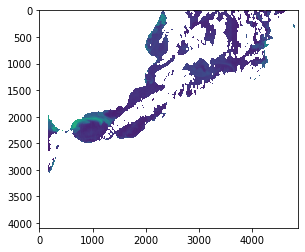

In [18]:
plt.imshow(CHL);

This is not the prettiest plot - Python can do much better. For a start, we may wish to look at a smaller area. We'll do this now, using the relevant indexes for area of data you wish to use. 



In [19]:
row1=1500
row2=3000
col1=500
col2=1500
grid_factor=2
CHL_subset = CHL[row1:row2:grid_factor, col1:col2:grid_factor]

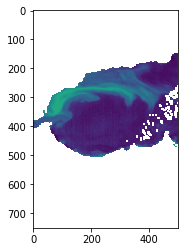

In [20]:
plt.imshow(CHL_subset);

You will notice a few problems with displaying plots like this. Firstly - they don't look very pretty (the colour scheme is not ideal, it is hard to see the coastline, and you can't differentiate the land from cloud), and secondly - the axes don't provide any information on the location (other than within the array) and there is no colour bar. 

To make a better plot we will need to add a few more tools to the libraries/modules we've currently imported. Below are a few lines of code to import cartopy (which will help us make a better, map based plot) and a few other tools to tweak how the data is displayed. 

The Cartopy is module allows us to use map projections to display data in a geographically relevant way. For those that are familiar to python, Cartopy has largely replaced the Basemap library.


In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

2021-12-14 12:16:03,226 DEBUG Trying `CDLL(/opt/conda/lib/libgeos_c.so.1)`
2021-12-14 12:16:03,229 DEBUG Library path: '/opt/conda/lib/libgeos_c.so.1'
2021-12-14 12:16:03,230 DEBUG DLL: <CDLL '/opt/conda/lib/libgeos_c.so.1', handle 557a074b0350 at 0x7f04b57f0af0>
2021-12-14 12:16:03,240 DEBUG Trying `CDLL(libc.so.6)`
2021-12-14 12:16:03,241 DEBUG Library path: 'libc.so.6'
2021-12-14 12:16:03,242 DEBUG DLL: <CDLL 'libc.so.6', handle 7f050e0f3920 at 0x7f04b57f0fd0>
2021-12-14 12:16:03,321 DEBUG GDAL data files are available at built-in paths
2021-12-14 12:16:03,323 DEBUG PROJ data files are available at built-in paths
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
2021-12-14 12:16:03,325 DEBUG Entering env context: <fiona.env.Env object at 0x7f04b12bd880>
2021-12-14 12:16:03,326 DEBUG Starting outermost env
2021-12-14 12:16:03,326 DEBUG No GDAL environment exists
2021-12-14 12:16:03,327 DEBUG New GDAL environment <fiona._env.GDALEnv object at 0x7f04b1

We will also need to load other data to make the plot - the longitude and latitude data associated with each pixel of the chlorophyll data. This data can be found in the geo_coordinates.nc file, within each S3 OLCI L2 folder. We load this in a very similar way to how we loaded the chlorophyll data, just with different file and variable names. The data path remains the same, referring the folder that contains all the netcdf files.


In [22]:
file_name_geo = 'geo_coordinates.nc'
GEO_file      = xr.open_dataset(os.path.join(input_root,input_path,file_name_geo))
LAT           = GEO_file.variables['latitude'][:]
LON           = GEO_file.variables['longitude'][:]
LAT_subset    = LAT[row1:row2:grid_factor, col1:col2:grid_factor]
LON_subset    = LON[row1:row2:grid_factor, col1:col2:grid_factor]
GEO_file.close()

Then we need to initialise the map we will use for plotting. The important things to choose here are:

1. the projection you wish to use (this may depend on your region of interest, particularly if you are looking at polar data, more information about the different projects is available here: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
2. The limits of your map (by default, this will be set to your data limits)
3. The resolution of the map coastline.

See more information about the options for Cartopy here: https://scitools.org.uk/cartopy/docs/latest/

(If you don't have cartopy installed, you can type "conda install -c scitools/label/archive cartopy" in your command prompt, with the anaconda distribution).

We start by defining a figure (line 1 below) and then defining a map projection (line 2). All mapping instructions are taken care of using our map object 'm'. Now we make the plot (this may take some time to draw!)

You can also save the figure using the code below (this will save in the folder where you are running the code, if you want to save elsewhere you need to specify the path).


2021-12-14 12:16:04,197 DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7f04b0cc2880>
2021-12-14 12:16:04,199 DEBUG Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x7f04b0cc2880> on colorbar
2021-12-14 12:16:04,200 DEBUG Setting pcolormesh
2021-12-14 12:16:04,329 DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
2021-12-14 12:16:04,330 DEBUG findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
2021-12-14 12:16:04,331 DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2021-12-14 12:16:04,332 DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2021-12-14 12:16:04,332 DEBUG findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2021-12-14 12:16:04,333 DEBUG findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10

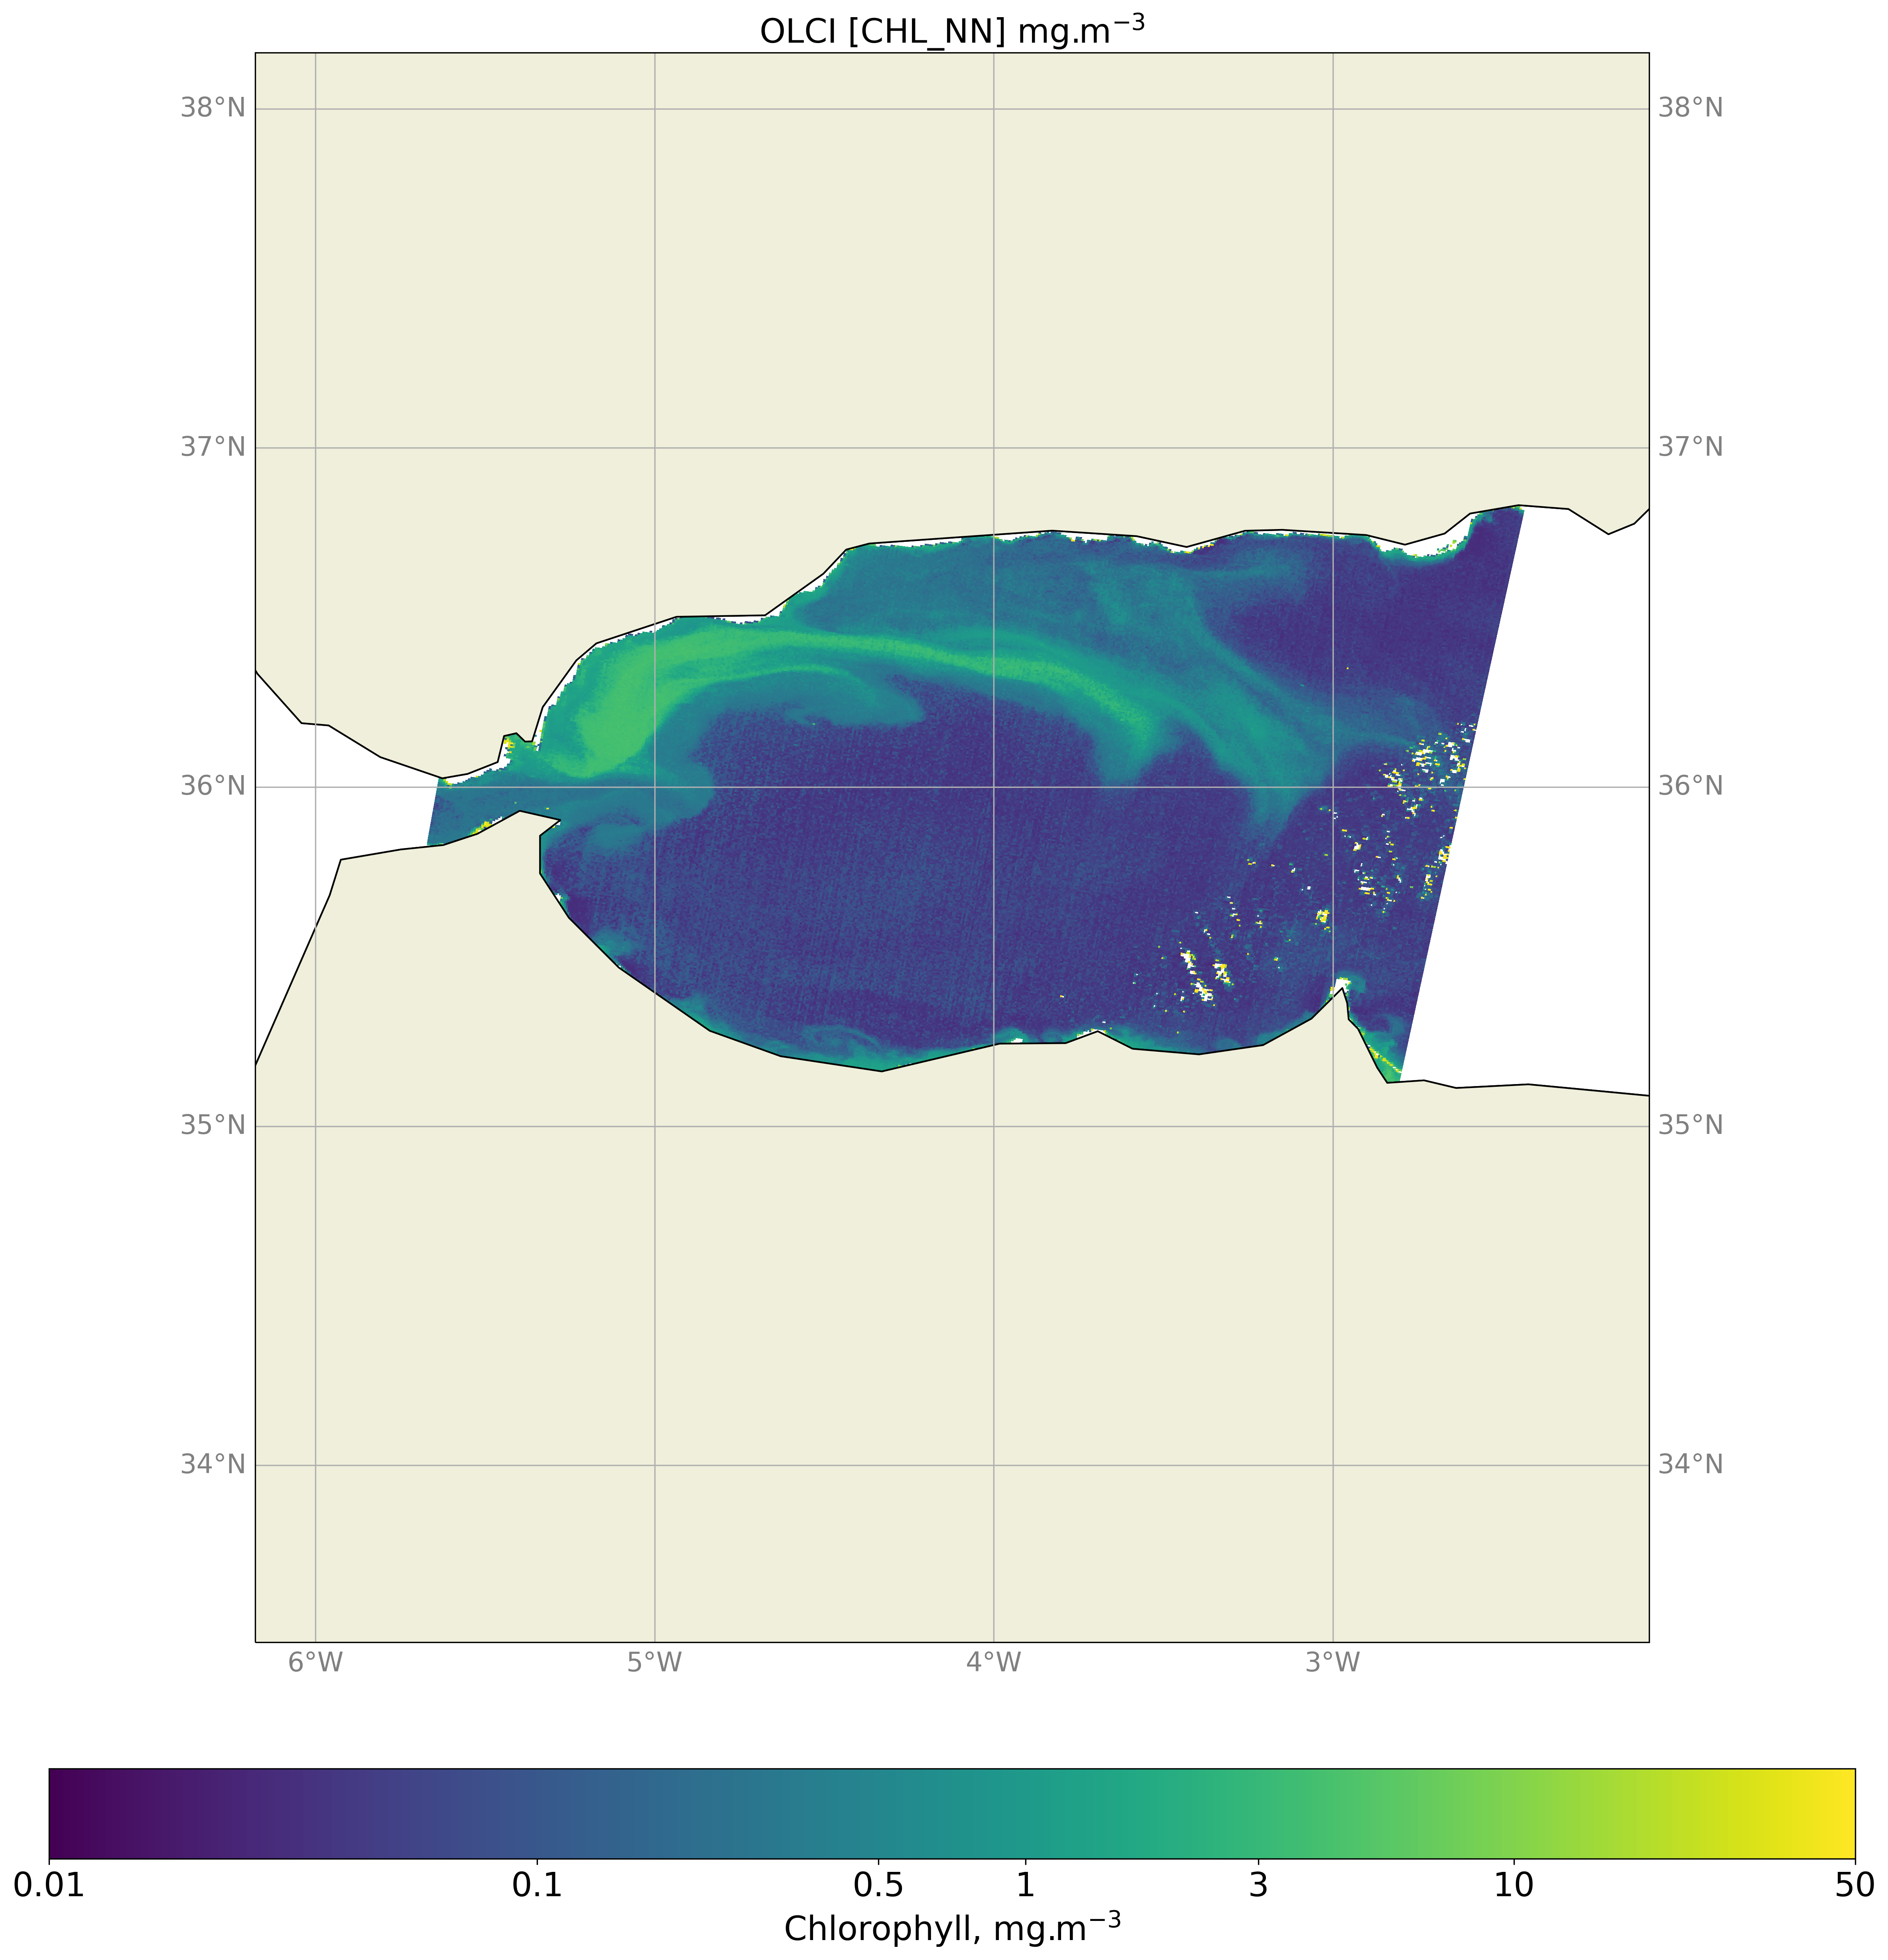

In [23]:
fig2 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)  
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [CHL_NN] mg.m$^{-3}$', fontsize=20);
plt.show()

In [24]:
fig2.savefig('OLCI_CHL_spatial_demo_no_flags.png', bbox_inches='tight')

However, this data is not flag masked. This means that we may have data that is subject to glint, or cloud, or a variety of other conditions that variously undermine quality. So, lets apply some flags. We are going to flag extensively, removing all data that corresponds to the following conditions...

In [25]:
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ANNOT_ABSO_D', 'ANNOT_MIXR1',
                 'ANNOT_TAU06']

file_name_flags = 'wqsf.nc'
FLAG_file = xr.open_dataset(os.path.join(input_root,input_path,file_name_flags))
# get all the flag names
flag_names = FLAG_file['WQSF'].flag_meanings.split(' ')
# get all the flag bit values
flag_vals = FLAG_file['WQSF'].flag_masks
# get the flag field itself
FLAGS = FLAG_file.variables['WQSF'].data
FLAG_file.close()

# make the flag mask using the function we defined above "flag_data_fast"
flag_mask = flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask = flag_mask.astype(float)
flag_mask[flag_mask == 0.0] = np.nan

# subset the flag mask
FLAG_subset = flag_mask[row1:row2:grid_factor, col1:col2:grid_factor]

And now we apply the flag data to our data and plot again...

2021-12-14 12:16:16,509 DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7f048b760fa0>
2021-12-14 12:16:16,510 DEBUG Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x7f048b760fa0> on colorbar
2021-12-14 12:16:16,511 DEBUG Setting pcolormesh


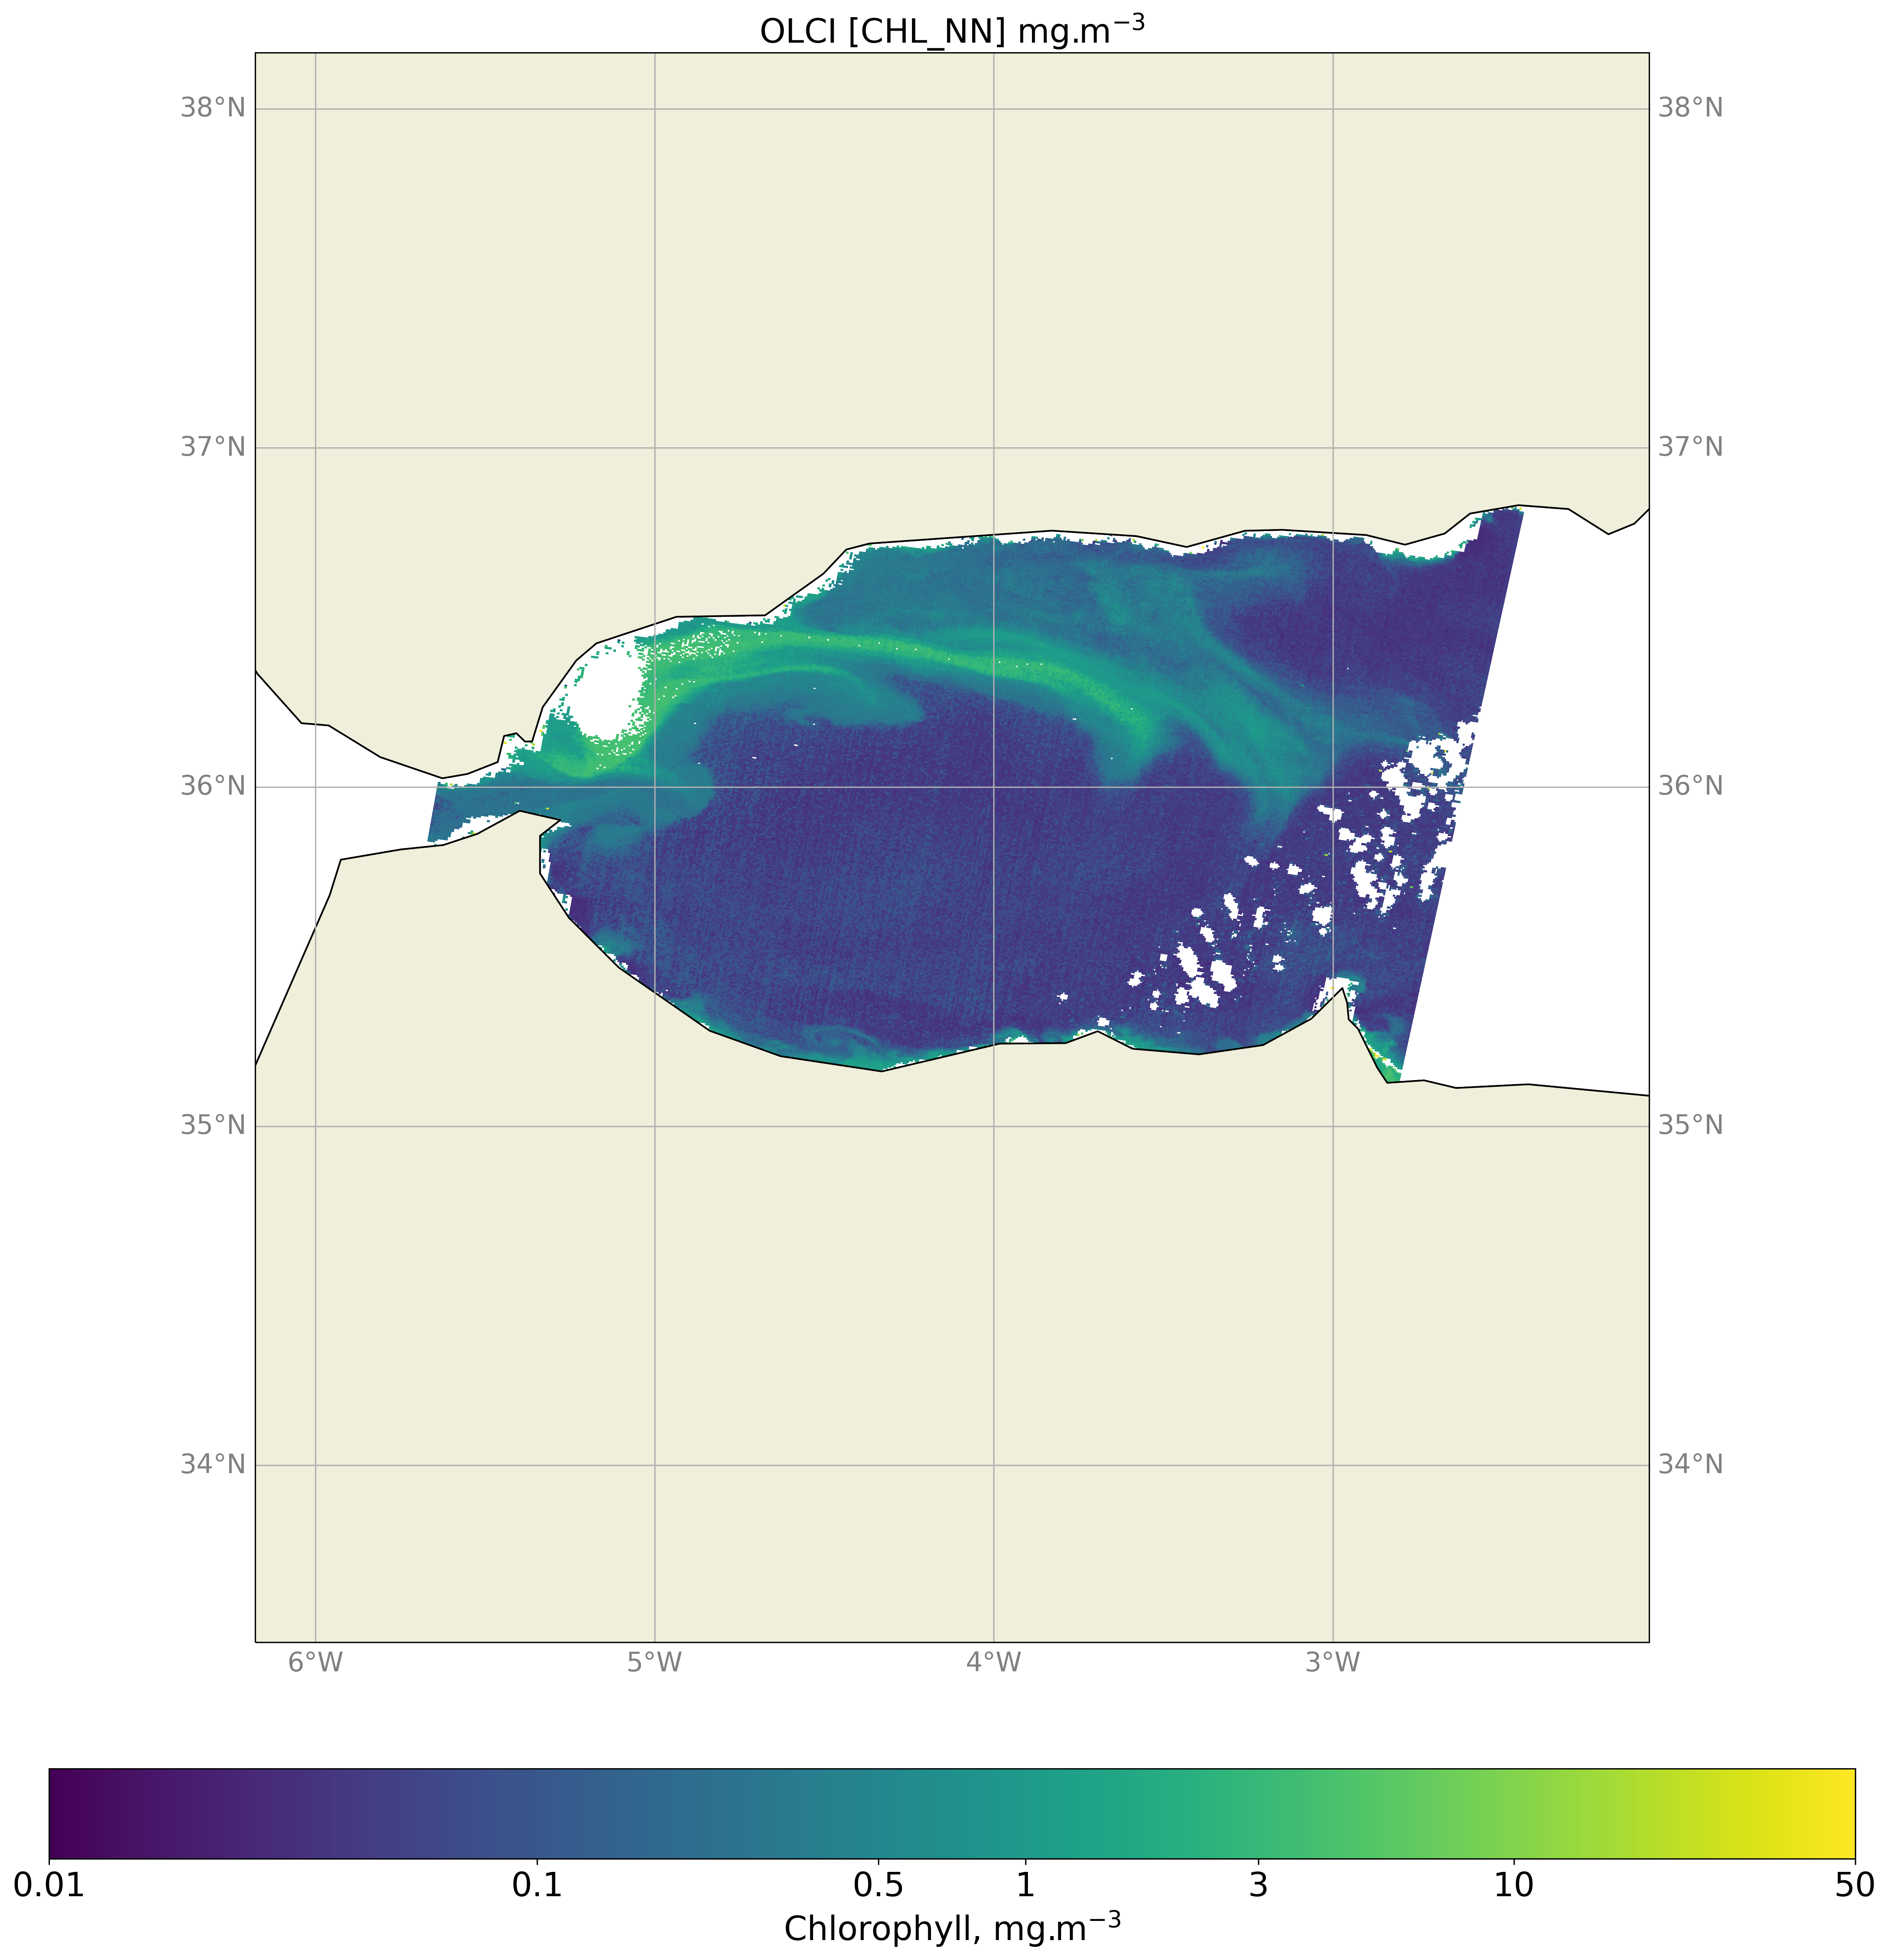

In [26]:
CHL_subset[np.isfinite(FLAG_subset)] = np.nan

fig3 = plt.figure(figsize=(20, 20), dpi=300)
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON_subset,LAT_subset,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)  
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [CHL_NN] mg.m$^{-3}$', fontsize=20);
plt.show()

In [27]:
fig3.savefig('OLCI_CHL_spatial_demo_flags.png', bbox_inches='tight')

The flags_we_want variable can be customised to any flag combination required, and, if you wish, the box above can be adapted to plot flags instead of the CHL field. You could also run the flags_we_want routine with each flag individually, to get a mask for every flag. That can then be used in more advanced plotting. But thats up to you...

<img src='./img/all_partners_wekeo.png' alt='' align='center' width='75%'></img>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://github.com/wekeo/wekeo-jupyter-lab">View on GitHub</a> | <a href="https://www.wekeo.eu/">WEkEO Website</a> | <a href=mailto:support@wekeo.eu>Contact</a></span></p>